In [1]:
# load spark
import findspark
findspark.init('C:\spark')
import pyspark
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("movies").setMaster("local")
sc = SparkContext(conf=conf)

## Prepare Data

In [2]:
# initiate a session with MongoDB server
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Python Spark SQL basic example").getOrCreate()

In [3]:
# load the database with the Movie Ratings
df = spark.read.format("mongo").option("uri","mongodb://127.0.0.1/netflix.movie_ratings").load()

In [4]:
# Load pyspark embedded recommender and evaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [5]:
# split the dataset to training and test
(training, test) = df.randomSplit([0.8, 0.2])

In [6]:
# show the first 20 rows of the training dataset
training.show()

+-------------------+-------+------+-------+--------------------+
|               Date|MovieID|Rating| UserID|                 _id|
+-------------------+-------+------+-------+--------------------+
|1999-12-09 01:00:00|     55|     1|1972971|{63bb03783c92eae3...|
|1999-12-20 01:00:00|     46|     3| 510180|{63bb03783c92eae3...|
|1999-12-25 01:00:00|     45|     2| 355883|{63bb03773c92eae3...|
|2000-01-05 01:00:00|     45|     1| 589368|{63bb03773c92eae3...|
|2000-01-05 01:00:00|     55|     3| 593765|{63bb03783c92eae3...|
|2000-01-06 01:00:00|     18|     4|1056435|{63bb03713c92eae3...|
|2000-01-06 01:00:00|     44|     3|1640271|{63bb03773c92eae3...|
|2000-01-06 01:00:00|     45|     1|1269887|{63bb03773c92eae3...|
|2000-01-06 01:00:00|     45|     2|1416849|{63bb03773c92eae3...|
|2000-01-06 01:00:00|     55|     3|2105516|{63bb03783c92eae3...|
|2000-01-07 01:00:00|     16|     2|1066384|{63bb03703c92eae3...|
|2000-01-07 01:00:00|     16|     3|1356928|{63bb03703c92eae3...|
|2000-01-0

## Exploratory Analysis

In [10]:
from pyspark.sql.functions import count, countDistinct
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [11]:
# count the users and the movies
df.select(countDistinct('UserID')).show()
df.select(countDistinct('MovieID')).show()

+----------------------+
|count(DISTINCT UserID)|
+----------------------+
|                480189|
+----------------------+

+-----------------------+
|count(DISTINCT MovieID)|
+-----------------------+
|                  17770|
+-----------------------+



In [12]:
# print the Schema
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [13]:
# show a summary of the dataset
df.summary().show(truncate=False)

+-------+-----------------+-----------------+------------------+
|summary|MovieID          |Rating           |UserID            |
+-------+-----------------+-----------------+------------------+
|count  |100480507        |100480507        |100480507         |
|mean   |9070.914762472286|3.604289964420661|1322488.5067232791|
|stddev |5131.890697186037|1.085218564629562|764536.8002745794 |
|min    |1                |1                |6                 |
|25%    |4676             |3                |661168            |
|50%    |9051             |4                |1318976           |
|75%    |13636            |4                |1984378           |
|max    |17770            |5                |2649429           |
+-------+-----------------+-----------------+------------------+



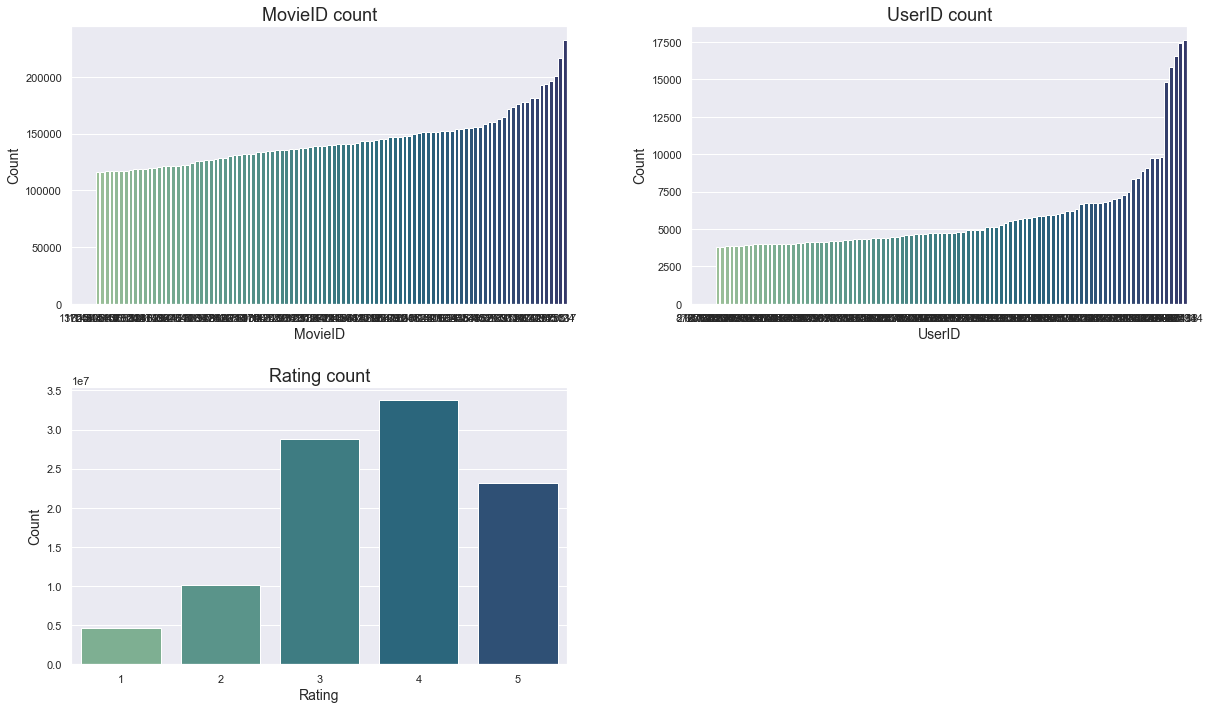

In [14]:
# generate plots
cols_for_display = ["MovieID", "UserID", "Rating"]
plt.figure(figsize=(20, 25))
for i, col in enumerate(cols_for_display, 1):
    plt.subplot(4, 2, i)
    
    # prepare the large columns
    if col in ["UserID", "MovieID"]:
        counts = df.groupBy(col).count().orderBy("count").toPandas()
        cc = pd.concat([counts.head(), counts.tail(100)], ignore_index=True)
        
        sns.barplot(x=col, 
                    y="count", 
                    data=cc, 
                    order=cc.sort_values("count")[str(col)],
                    palette="crest")
    else:
        sns.barplot(x=col, 
                y="count", 
                data=df.groupBy(col).count().toPandas(),
                palette="crest")
      
    # specify labels, title and their size
    plt.xlabel(col, size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{col} count", size=18)
    
plt.subplots_adjust(hspace=0.3, wspace=0.25)

## Model

In [15]:
# build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="UserID", itemCol="MovieID", ratingCol="Rating",coldStartStrategy="drop")
model = als.fit(training)

In [16]:
# evaluate the model
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMS error: " + str(rmse))

RMS error: 1.8262732631389997


## Generate Recommendations

In [17]:
# generate recomendation for 3 users
users = df.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)

In [18]:
# show the recommendations
userSubsetRecs.show()

+-------+--------------------+
| UserID|     recommendations|
+-------+--------------------+
| 737709|[{46, 6.2216425},...|
|1268699|[{7, 5.554359}, {...|
|2152168|[{77, 6.53745}, {...|
+-------+--------------------+



## References
- https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation/notebook
- https://www.mongodb.com/docs/spark-connector/master/python/read-from-mongodb/
- https://www.mongodb.com/docs/manual/core/map-reduce/
- https://sparkbyexamples.com/pyspark/install-pyspark-in-anaconda-jupyter-notebook/
- https://www.datacamp.com/tutorial/installation-of-pyspark#windows-installation
- https://www.apache.org/dyn/closer.lua/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
- https://mvnrepository.com/artifact/org.mongodb/mongo-java-driver/3.12.11
- https://mvnrepository.com/artifact/org.mongodb.spark/mongo-spark-connector_2.13
- https://medium.com/@sajad1009/netflix-recommendation-system-with-pyspark-3c25121a9144
- https://github.com/Sajad1009/Netflix-Recommendation-System-/blob/master/spark_recommendition.ipynb
- https://www.jakobsalomonsson.com/projects/100-million-ratings-with-spark.html
- https://github.com/JakobLS/100-million-rows-with-spark/blob/main/100-Million-Ratings-with-Spark-on-a-Mac-M1.ipynb
- https://medium.com/@patelneha1495/recommendation-system-in-python-using-als-algorithm-and-apache-spark-27aca08eaab3